In [0]:
%matplotlib inline
import warnings
import pickle
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import seaborn as sn
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
import scikitplot.metrics as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
from scipy.sparse import find


# Utility Function

In [0]:
#Utility Function
def standardisation(mean,final_counts,final_counts_test):
  s = StandardScaler(with_mean = mean)
  standardized_data = s.fit_transform(final_counts)
  standardized_data_test = s.transform(final_counts_test)
  return (standardized_data,standardized_data_test)
  
def lr_classifier_random():
  c = [0.001,0.01,0.1,1,10,100,1000]
  #c = [1000]
  p = ['l1','l2']
  #scoring = ['accuracy','f1_micro']
  #p = ['l1']
  tss = TimeSeriesSplit(n_splits=2)
  lr = LogisticRegression()
  parameter = {'penalty': p, 'C' : c, 'class_weight':[{0:5.5,1:1}]}
  clf = RandomizedSearchCV(estimator = lr,param_distributions = parameter,verbose = 1,scoring = 'roc_auc',cv=tss, n_jobs = 2)
  return clf

def lr_classifier():
  c = [0.001,0.01,0.1,1,10,100,1000]
  #scoring = ['accuracy','f1_micro']
  p = ['l1','l2']
  tss = TimeSeriesSplit(n_splits=2)
  lr = LogisticRegression()
  parameter = {'penalty': p, 'C' : c,'class_weight':[{0:5.5,1:1}]}
  clf = GridSearchCV(estimator = lr,param_grid = parameter,verbose = 1,scoring = 'roc_auc', cv=tss, n_jobs = 2)
  return clf
  
   

def train_set_report(clf):
  best_parameters = clf.best_params_
  best_accuracy = clf.best_score_
  print(best_parameters)
  print(best_accuracy)
  
def test_set_report(clf,x_test,y_test):
  pred = clf.predict(standardized_data_test)
  acc = accuracy_score(y_test, pred) * 100
  print('The test set accuracy is %f%%' %(acc))
  skplt.plot_confusion_matrix(y_test ,pred)
  print(classification_report(y_test ,pred))

def lrclassifierresults(clf):
  out = pd.DataFrame.from_dict(clf.cv_results_)
  return out

def checkSparsity(c,x,y,xt,yt):
  clf = LogisticRegression(C = c, penalty= 'l1')
  clf.fit(x,y)
  pred = clf.predict(xt)
  ac = accuracy_score(yt, pred)*100
  cou = np.count_nonzero(clf.coef_)
  print("Number of non-zero weights for "+ str(c)+" = "+ str(cou))
  print("Accuracy for "+ str(c)+" = "+ str(ac))

def plotgraph(a):
    a= a.sort_values(by = ['param_C'])
    b = a[a["param_penalty"] == 'l1']
    c = a[a["param_penalty"] == 'l2']
    kl1 = b.param_C.tolist()
    scorel1 = b.mean_test_score.tolist()
    kl2 = c.param_C.tolist()
    scorel2 = c.mean_test_score.tolist()
    plt.plot(kl1,scorel1,color='blue',label = "L1")
    plt.plot(kl2,scorel2,color='green',label = "L2")
    plt.legend()
    #plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
    plt.title("lambda vs accuracy score for L1 and L2 regularisation")
    plt.xlabel('Lambda')
    plt.ylabel('Accuracy score')
    plt.show()

def checkMultiCollinearity(x_train, y_train,xt,yt):
  clf = LogisticRegression(C = 0.001, penalty= 'l2')
  clf.fit(x_train,y_train)
  pred = clf.predict(xt)
  weights = find(clf.coef_[0])[2]
  xtrainw = x_train
  noise = np.random.uniform(low=-0.01, high=0.01, size=(find(xtrainw)[0].size,))
  q,w,e = find(xtrainw)
  xtrainw[q,w] = noise + xtrainw[q,w]
  clfw = LogisticRegression(C = 0.001, penalty= 'l2')
  clfw.fit(xtrainw,y_train)
  weightsw = find(clfw.coef_[0])[2]
  weight_diff = (abs(weights - weightsw)/weights) * 100
  number = weight_diff[np.where(weight_diff > 30.0)].size
  print("Size of weights to check multicollinearity is " + str(weight_diff.size) + " . Number of weights having a change greater then 30% is " + str(number))

def topfeatures(vectorizer, clf, n=20):#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
  



# Data Sampling

In [0]:
con = sqlite3.connect('/content/drive/My Drive/Dataset/AFR/final.sqlite')

In [0]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [0]:
import datetime

final["Time"] = final["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


In [0]:
final1 = final.iloc[0:100000]


In [0]:
final = pd.read_pickle('/content/drive/My Drive/Dataset/AFR/final_100000.pkl')

In [216]:
final.shape

(100000, 12)

In [0]:
l = final['Score']
final = final.drop("Score", axis = 1)


In [219]:
#negative
#positive

def partition(x):
    if x == 'positive':
        return 1
    return 0
l1 = l.map(partition)
Counter(l1)

Counter({0: 12271, 1: 87729})

In [0]:
X_train, X_test, y_train, y_test = train_test_split(final, l1, test_size=0.3, random_state=0)

# BOW

In [355]:
import time
start_time = time.time()
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_train['CleanedText'].values)
print("--- %s seconds ---" % (time.time() - start_time))
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

--- 2.5719869136810303 seconds ---
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 31572)
the number of unique words  31572


In [0]:
scipy.sparse.save_npz('bowsparse_matrix_100000.npz', final_counts)

In [356]:
import time
start_time = time.time()
final_counts_test = count_vect.transform(X_test['CleanedText'].values)
print(final_counts.shape)
print(final_counts_test.shape)

(70000, 31572)
(30000, 31572)


In [0]:
scipy.sparse.save_npz('bowsparse_matrix_100000_test.npz', final_counts_test)


In [0]:
y_train.shape

(70000,)

In [0]:
standardized_data, standardized_data_test = standardisation(False,final_counts,final_counts_test)

In [0]:
bow_lr = lr_classifier()

In [359]:
bow_lr.fit(standardized_data, y_train)


Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed: 39.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [0]:
with open('bow_lr_auc.pkl', 'wb') as f:
    pickle.dump(bow_lr, f)

In [0]:
a = lrclassifierresults(bow_lr)

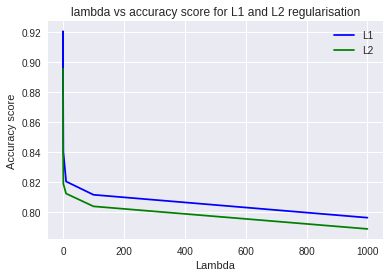

In [377]:
plotgraph(a)

In [365]:
train_set_report(bow_lr)

{'C': 0.01, 'class_weight': {0: 5.5, 1: 1}, 'penalty': 'l1'}
0.920550743509769


The test set accuracy is 90.680000%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



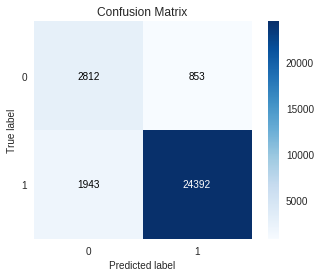

In [366]:
test_set_report(bow_lr,standardized_data_test,y_test)

**Random** **CV**

In [0]:
bow_lr_random = lr_classifier_random()

In [368]:
bow_lr_random.fit(standardized_data, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 14.4min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [369]:
train_set_report(bow_lr_random)

{'penalty': 'l1', 'class_weight': {0: 5.5, 1: 1}, 'C': 0.01}
0.9205091494091433


The test set accuracy is 90.690000%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



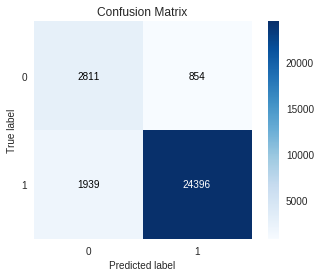

In [370]:
test_set_report(bow_lr_random,standardized_data_test,y_test)

In [0]:
b = lrclassifierresults(bow_lr_random)

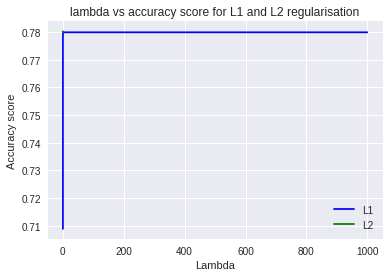

In [371]:
plotgraph(b)

**Check Sparsity**

In [372]:
c = [1000,10,0.0001,0.8]
for i in c:
  checkSparsity(i,standardized_data,y_train,standardized_data_test,y_test)
  

Number of non-zero weights for 1000 = 20777
Accuracy for 1000 = 87.88666666666667
Number of non-zero weights for 10 = 14968
Accuracy for 10 = 88.38000000000001
Number of non-zero weights for 0.0001 = 0
Accuracy for 0.0001 = 87.78333333333333
Number of non-zero weights for 0.8 = 12419
Accuracy for 0.8 = 90.01666666666667


**Check Multicollinearity**

In [373]:
checkMultiCollinearity(standardized_data, y_train,standardized_data_test,y_test)

Size of weights to check multicollinearity is 31572 . Number of weights having a change greater then 30% is 230


**Feature Selection**

In [0]:
clf = LogisticRegression(C = 0.0001, penalty= 'l2')
clf.fit(standardized_data,y_train)
#topfeatures(vectorizer, clf, n=20)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
topfeatures(count_vect, clf, n=20)

	-0.1081	disappoint     				0.2101	great          
	-0.0838	worst          				0.1754	love           
	-0.0723	terribl        				0.1453	best           
	-0.0670	horribl        				0.1311	good           
	-0.0636	aw             				0.1144	delici         
	-0.0611	return         				0.0982	excel          
	-0.0563	bad            				0.0878	favorit        
	-0.0557	money          				0.0839	perfect        
	-0.0544	unfortun       				0.0788	nice           
	-0.0544	wast           				0.0784	wonder         
	-0.0540	threw          				0.0745	tasti          
	-0.0509	thought        				0.0739	find           
	-0.0480	bland          				0.0739	easi           
	-0.0471	stale          				0.0671	thank          
	-0.0452	mayb           				0.0613	enjoy          
	-0.0408	wors           				0.0608	use            
	-0.0407	tasteless      				0.0602	price          
	-0.0403	disgust        				0.0591	make           
	-0.0401	weak           				0.0589	high           
	-0.0400	poor           				0.0

# TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)

In [17]:
#scipy.sparse.save_npz('tfidfsparse_matrix_100000.npz', final_counts)
print("type = ", type(final_tf_idf))
print("shape = ", final_tf_idf.get_shape())
print("number of unique words ", final_tf_idf.get_shape()[1])

type =  <class 'scipy.sparse.csr.csr_matrix'>
shape =  (70000, 31572)
number of unique words  31572


In [0]:
final_tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)

**GridSearch**

In [0]:
tfidf_lr = lr_classifier()

In [0]:
standardized_data, standardized_data_test = standardisation(False,final_tf_idf,final_tf_idf_test)

In [276]:
tfidf_lr.fit(standardized_data,y_train)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed: 26.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [277]:
train_set_report(tfidf_lr)

{'C': 0.01, 'class_weight': {0: 5.5, 1: 1}, 'penalty': 'l1'}
0.9286316222041252


The test set accuracy is 90.606667%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



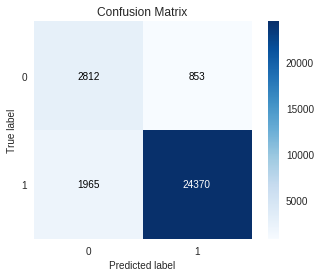

In [278]:
test_set_report(tfidf_lr,standardized_data_test,y_test)

In [0]:
a = lrclassifierresults(tfidf_lr)

In [0]:
b = lrclassifierresults(tfidf_lr)

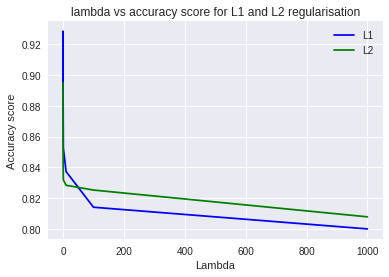

In [286]:
plotgraph(b)


**Random**

In [0]:
tfidf_lr_rndom = lr_classifier_random()

In [255]:
tfidf_lr_rndom.fit(standardized_data,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 12.6min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [256]:
train_set_report(tfidf_lr_rndom)

{'penalty': 'l1', 'class_weight': {0: 5.5, 1: 1}, 'C': 0.01}
0.928632021478328


The test set accuracy is 90.606667%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



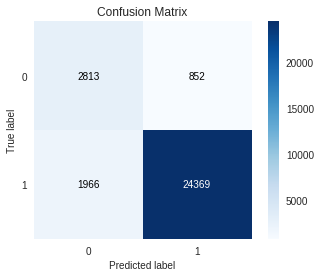

In [257]:
test_set_report(tfidf_lr_rndom,standardized_data_test,y_test)

In [0]:
b = lrclassifierresults(tfidf_lr_rndom)

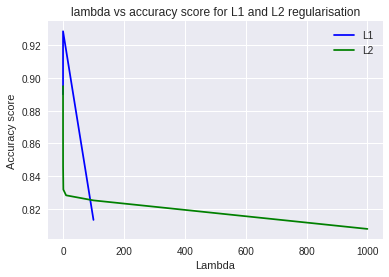

In [263]:
plotgraph(b)

**Check Sparsity**

In [0]:
c = [1000,10,0.0001,0.8]
for i in c:
  checkSparsity(i,standardized_data,y_train,standardized_data_test,y_test)
  

Number of non-zero weights for 1000 = 18139
Accuracy for 1000 = 87.26
Number of non-zero weights for 10 = 15654
Accuracy for 10 = 87.93666666666667
Number of non-zero weights for 0.0001 = 0
Accuracy for 0.0001 = 87.78333333333333
Number of non-zero weights for 0.8 = 14261
Accuracy for 0.8 = 89.21333333333334


**MULTI COLLINEARITY**

In [0]:
checkMultiCollinearity(standardized_data, y_train,standardized_data_test,y_test)

Size of weights to check multicollinearity is 31572 . Number of weights having a change greater then 30% is 93


**TOP FEATURES**

In [0]:
clf = LogisticRegression(C = 0.0001, penalty= 'l2')
clf.fit(standardized_data,y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
topfeatures(tf_idf_vect, clf, n=20)

	-0.0995	disappoint     				0.1663	great          
	-0.0814	worst          				0.1455	love           
	-0.0692	terribl        				0.1225	best           
	-0.0671	horribl        				0.1128	good           
	-0.0619	aw             				0.0951	delici         
	-0.0605	return         				0.0802	excel          
	-0.0547	wast           				0.0758	favorit        
	-0.0530	threw          				0.0752	perfect        
	-0.0514	stale          				0.0717	find           
	-0.0490	bland          				0.0697	nice           
	-0.0482	money          				0.0678	wonder         
	-0.0479	unfortun       				0.0654	make           
	-0.0469	bad            				0.0649	use            
	-0.0436	thought        				0.0626	tasti          
	-0.0413	mayb           				0.0599	easi           
	-0.0411	weak           				0.0576	thank          
	-0.0405	tasteless      				0.0564	enjoy          
	-0.0403	disgust        				0.0548	high           
	-0.0396	wors           				0.0539	littl          
	-0.0376	refund         				0.0

# AVGW2V

In [0]:
def wordList(sentence):
    listword = []
    for sent in sentence:
        listword.append(sent.split())
    return listword
        

In [0]:
list_clean_text = wordList(X_train['CleanedText'].values)

In [0]:
list_clean_text_test = wordList(X_test['CleanedText'].values)

In [43]:
import time
start_time = time.time()
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 300, workers = -1 )
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9984514713287354 seconds ---


In [46]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 10738
sample words ['purchas', 'wedg', 'oro', 'central', 'market', 'cost', 'say', 'impress', 'look', 'hard', 'chees', 'add', 'mixtur', 'bacon', 'wrap', 'jalapeno', 'turn', 'great', 'choic', 'usual', 'use', 'parmesan', 'realli', 'want', 'tri', 'someth', 'new', 'also', 'grate', 'caesar', 'salad', 'sharp', 'flavor', 'went', 'dress', 'bold', 'nose', 'soft', 'finish', 'pair', 'red', 'white', 'wine', 'whatev', 'reason', 'give', 'think', 'pleasant', 'surpris', 'wont']


In [47]:
type(w2v_words)

list

In [0]:
def w2vavg(clean,w2v_model,w2v_words):
    sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in clean:
        sent_vec = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors


In [52]:
import time
start_time = time.time()
sent_vectors_train = w2vavg(list_clean_text,w2v_model,w2v_words)
print("--- %s seconds ---" % (time.time() - start_time))
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

--- 66.08126473426819 seconds ---
70000
300


In [53]:
sent_vectors_test = w2vavg(list_clean_text_test,w2v_model,w2v_words)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
300


In [0]:
sent_vectors_final_train = np.asarray(sent_vectors_train)

In [0]:
sent_vectors_final_test = np.asarray(sent_vectors_test)

In [0]:
standardized_data, standardized_data_test = standardisation(True,sent_vectors_final_train,sent_vectors_final_test)

In [68]:
standardized_data.shape

(70000, 300)

In [0]:
avgw2vlr = lr_classifier()

In [288]:
avgw2vlr.fit(standardized_data,y)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed: 26.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [289]:
train_set_report(avgw2vlr)

{'C': 0.01, 'class_weight': {0: 5.5, 1: 1}, 'penalty': 'l1'}
0.9286280760871938


The test set accuracy is 90.606667%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



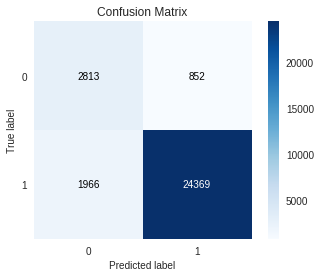

In [290]:
test_set_report(avgw2vlr,standardized_data_test,Y_test)

In [0]:
a = lrclassifierresults(avgw2vlr)

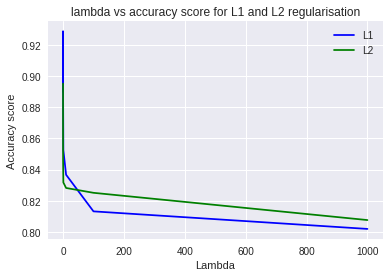

In [293]:
plotgraph(a)

**Randomized Search**

In [0]:
avgw2v_lr_rndom = lr_classifier_random()

In [297]:
avgw2v_lr_rndom.fit(standardized_data,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 13.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [298]:
train_set_report(avgw2v_lr_rndom)

{'penalty': 'l1', 'class_weight': {0: 5.5, 1: 1}, 'C': 0.01}
0.9286323490253823


The test set accuracy is 90.610000%
             precision    recall  f1-score   support

          0       0.59      0.77      0.67      3665
          1       0.97      0.93      0.95     26335

avg / total       0.92      0.91      0.91     30000



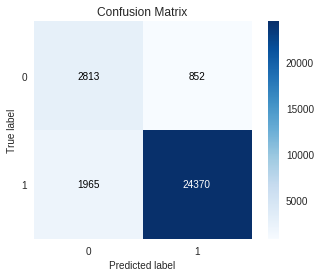

In [299]:
test_set_report(avgw2v_lr_rndom,standardized_data_test,y_test)

In [0]:
b = lrclassifierresults(avgw2v_lr_rndom)

In [0]:
a = pd.read_pickle("/content/drive/My Drive/Dataset/AFR/avgw2v_lr_rndom.pkl")

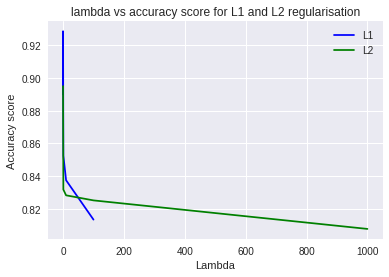

In [301]:
plotgraph(b)

**Check Sparsity**

In [352]:
c = [1000,10,0.0001,0.8]
for i in c:
  checkSparsity(i,standardized_data,y_train,standardized_data_test,y_test)
  

Number of non-zero weights for 1000 = 300
Accuracy for 1000 = 89.08
Number of non-zero weights for 10 = 300
Accuracy for 10 = 89.08
Number of non-zero weights for 0.0001 = 0
Accuracy for 0.0001 = 87.78333333333333
Number of non-zero weights for 0.8 = 299
Accuracy for 0.8 = 89.07666666666667


**MultiCollinearity**

In [2]:
checkMultiCollinearity(standardized_data, y_train,standardized_data_test,y_test)

Size of weights to check multicollinearity is 300 . Number of weights having a change greater then 30% is 0


# tfidfw2v

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


In [0]:
# TF-IDF weighted Word2Vec
def tfidfw2v(dictionary,list_clean_text,w2v_model,w2v_words):
    tfidf_sent_vectors = []
    row = 0
    for sent in list_clean_text: # for each review/sentence 
        sent_vec = np.zeros(300) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                #tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent)) 
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
                
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [321]:
import time
start_time = time.time()
sent_vectors_train = tfidfw2v(dictionary,list_clean_text,w2v_model,w2v_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print("--- %s seconds ---" % (time.time() - start_time))


70000
300
--- 75.15233111381531 seconds ---


In [326]:
sent_vectors_test = tfidfw2v(dictionary,list_clean_text_test,w2v_model,w2v_words)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
300


In [0]:
sent_vectors_final_train = np.asarray(sent_vectors_train)
sent_vectors_final_test  = np.asarray(sent_vectors_test)


In [331]:
sent_vectors_final_test.shape

(30000, 300)

In [0]:
standardized_data, standardized_data_test = standardisation(False,sent_vectors_final_train,sent_vectors_final_test)

In [0]:
tfidfw2v_lr = lr_classifier()

In [334]:
tfidfw2v_lr.fit(standardized_data,y_train)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed:  1.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [335]:
train_set_report(tfidfw2v_lr)

{'C': 0.001, 'class_weight': {0: 5.5, 1: 1}, 'penalty': 'l2'}
0.7803013051712366


The test set accuracy is 77.506667%
             precision    recall  f1-score   support

          0       0.30      0.61      0.40      3665
          1       0.94      0.80      0.86     26335

avg / total       0.86      0.78      0.80     30000



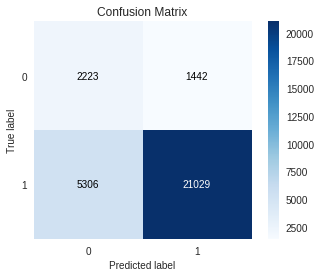

In [336]:
test_set_report(tfidfw2v_lr,standardized_data_test,y_test)

In [0]:
b = lrclassifierresults(tfidfw2v_lr)

In [0]:
a = pd.read_pickle("/content/drive/My Drive/Dataset/AFR/tfidfw2v_lr_300.pkl")

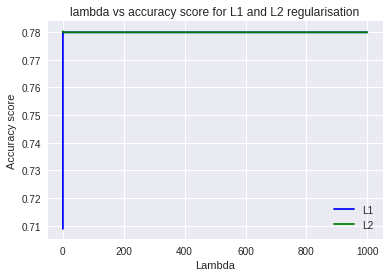

In [338]:
plotgraph(b)

**RandomCV**

In [0]:
tfidfw2v_lr_random = lr_classifier_random()

In [340]:
tfidfw2v_lr_random.fit(standardized_data,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   48.1s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{0: 5.5, 1: 1}]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [341]:
train_set_report(tfidfw2v_lr_random)

{'penalty': 'l2', 'class_weight': {0: 5.5, 1: 1}, 'C': 0.001}
0.7803013051712366


The test set accuracy is 77.506667%
             precision    recall  f1-score   support

          0       0.30      0.61      0.40      3665
          1       0.94      0.80      0.86     26335

avg / total       0.86      0.78      0.80     30000



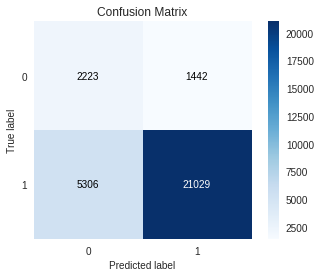

In [342]:
test_set_report(tfidfw2v_lr_random,standardized_data_test,y_test)

In [0]:
b = lrclassifierresults(tfidfw2v_lr_random)

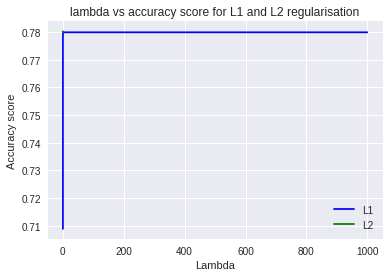

In [344]:
plotgraph(b)

**Check Sparsity**

In [346]:
c = [1000,10,0.0001,0.8]
for i in c:
  checkSparsity(i,standardized_data,y_train,standardized_data_test,y_test)

Number of non-zero weights for 1000 = 300
Accuracy for 1000 = 88.08666666666667
Number of non-zero weights for 10 = 300
Accuracy for 10 = 88.09
Number of non-zero weights for 0.0001 = 0
Accuracy for 0.0001 = 87.78333333333333
Number of non-zero weights for 0.8 = 300
Accuracy for 0.8 = 88.09666666666666


**Check Multicollinearity**

In [345]:
checkMultiCollinearity(standardized_data, y_train,standardized_data_test,y_test)

Size of weights to check multicollinearity is 300 . Number of weights having a change greater then 30% is 0


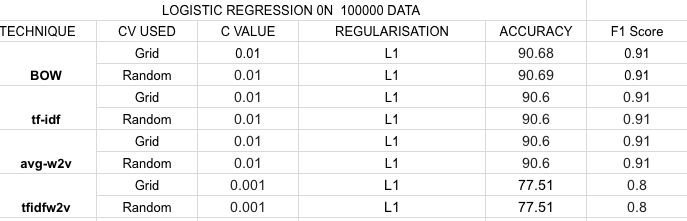

In [1]:
from IPython.display import Image
Image(filename='/Users/amarnathmanipatra/Desktop/123.png')

# Conclusion

1) BOW produced the best accuracy of 90.69% 
2) Sparsity increases as we increase the value of c for l1 penalty 
3) BOW and tf-idf had multicolinear features where as avgw2v and tf-idf features were not collinear.